# Convert NETCDF files to COG format (GTIF)
A Cloud Optimized GeoTIFF (COG) is a regular GeoTIFF file, aimed at being hosted on a HTTP file server, with an internal organization that enables more efficient workflows on the cloud. It does this by leveraging the ability of clients issuing ​HTTP GET range requests to ask for just the parts of a file they need.

This notebook converst a file and convert it to COG **using gdal-python on a notebook** and also has the instructions to make the conversion **using gdal on command window** .  

# 0. Libraries

In [ ]:
import rioxarray as rio
import xarray as xr
from pyproj import CRS
from affine import Affine
import rasterio
import netCDF4
import matplotlib
import glob
from osgeo import gdal
from osgeo import gdal
import datetime
%matplotlib inline

In [ ]:
# Uncomment to find out full path
!pwd

# 1. Create the name of files based on its time
Each band of the NC file corresponds to an acquisition of every 30 minutes, and that time is in UNIX format on its name. Since the final COG files should have the time stamp in dd-mm-yyyy format, this cell generates a list with the correspondent timestamp to be used for the naming of each output COG file.

In [ ]:
# OPEN MULTIPLE DATASETS FROM ONE FOLDER  #################################################################################
# OPEN MULTIPLE DATASETS (TO DO:Create list with all files inside the path ending with *.tif and pass the loop below for each elment of this list

######### SELECT HERE WHICH FOLDER TO COVERT! ####################
ds = list(glob.glob("LOOP/*.nc")) 
#for xds in ds:
ds   

In [ ]:
dates = []
for i in range(0,len(ds)):
    xds = xr.open_dataset(ds[i])
    
# The time in this file is in UNIX format and needs to be changed to timestamp
# Creates a list with the dates associated to each band of the netcdf
    listOfTime = xds.time
    for i in listOfTime:
        unixToDatetime = datetime.datetime.fromtimestamp(i) # Unix Time
        dates.append(str(unixToDatetime))

#Umcomment to see result
#print(dates)

In [ ]:
# Re-writting the dates to become the format "yyyymmddThh_mm_ssZ_gtif_uibk_ffp_values"
test_list = dates
char = '-'
char2 = ":"
char3 = " "
# Remove character from Strings list
# using loop + replace() + enumerate()
for idx, ele in enumerate(test_list):
        test_list[idx] = ele.replace(char, '')
        
for idx, ele in enumerate(test_list):
        test_list[idx] = ele.replace(char2, '')

for idx, ele in enumerate(test_list):
        test_list[idx] = ele.replace(char3, 'T')

#Umcomment to see result
print(test_list[0:5])

In [ ]:
# Convert it to a pandas dataframe
import pandas as pd
test_list = [item + 'Z_gtif_uibk_ffp_values' for item in test_list]

#Uncomment to see result
#test_list[0:5]

In [ ]:
df = pd.DataFrame(test_list)
#df['band']=range(48)
#df['band']=df['band']+1

# Uncomment to see the names of files, and head and tail of the df
#df
print('Total number of of files to be generated:', len(df))
#df.head()
#df.tail()

## 2. Converts netcdf file to TIF -> Reprojects -> Coverts to COG 
- Extracts the **ffp_value** and creates a ffp_value tif for each of the 48 bands
- The orginal gdal script on the command window to convert a NETCDF to TIFF is:
-- **gdal_translate -of GTiff NETCDF:"input.nc":ffp_values -b 1 output.tif -a_srs EPSG:4326 -a_ullr 11.379291 47.268726 11.392094 47.259460**
- The original gdal script on the command window to reproject a TIFF is:
- - **gdalwarp -t_srs EPSG:3857 input.tif output.tif**
- The original gdal script on the command window to convert a TIFF to COG is:
-- **gdal_translate input.tif output.tif -of COG -co COMPRESS=LZW**
- On python API this would be:
-- **ds = gdal.Translate('output.tif', 'input.tif', options="-of GTiff -co COMPRESS=LZW")**

In [ ]:
i = 0
df.iloc[i][0] 

In [ ]:
#Settings for the conversion to TIFF
projection = '-a_srs EPSG:4326 '
output_format = ' -of GTiff'
#Settings for the conversion to COG
compression =  ' -co COMPRESS=LZW'
output_format2 = ' -of COG'

# Loops through the list of path to each ncfile
for i in range(0,len(ds)):

# Define path name where netcdf is
    old_name = ds[i]
    # Name of the varialbe to be extracted
    var_name = 'ffp_values'
    # Writes the netcdf with selected varialbe in the format to be used/read for the gdal translate
    sublayername =  gdal.Open('NETCDF:"{0}":{1}'.format(old_name, var_name ),gdal.GA_ReadOnly)

# Making a loop through all the future names of the files
    for i in range(0,len(df)):
    
        #Creates the output name where each band/TIF file will be stored
        outname = old_name[0:5] + df.iloc[i][0] + 'Intermediate.tif'
        #print('\n Verifying if outputname is correct. The output name is: ',outname)
            
        for e in range(1,48):
        # Defines that band (this is one of the settings to convert to TIF)
            band = ' -b '+str(e)
    
            # SAVES EACH BAND OF NC FILE TO TIFF #################################################################################################
            # Performs the GDAL translate to the band 
            translateOptionText = projection + output_format + band +' -a_ullr '  + str(11.379291) + ' ' + str(47.268726) + ' ' + str(11.392094) + ' ' + str(47.259460)
            #print('\n Verifying if the command is correct. The command is: ', translateOptionText) 
            translateOptions = gdal.TranslateOptions(gdal.ParseCommandLine(translateOptionText))
            gdal.Translate(outname,sublayername,options = translateOptions)
print('INTERMEDIATE DONE')
for i in range(0,len(df)):

        # REPROJECTING TO ESPG: 3857 ############################################################################################
        old_name[0:5]
        inname =  old_name[0:5] + df.iloc[i][0] + 'Intermediate.tif'
        outname = old_name[0:5] + df.iloc[i][0] + 'Reprojected.tif'
        #print("Confirming Output file name is:", outname)
        #print("Confirming Input file name is :", inname)
        ds = gdal.Warp(outname, inname, dstSRS='EPSG:3857')
        del ds
    
        # CONVERTST REPROJECTED TIF TO COG ######################################################################################
        inname2 =  old_name[0:5] + df.iloc[i][0] + 'Reprojected.tif'
        outname2 = old_name[0:5] + df.iloc[i][0] + '.tif'
        #print("Confirming Output file name is:", outname)
        #print("Confirming Input file name is :", inname)
        ds = gdal.Translate(outname2, inname2, options=" -of COG -co COMPRESS=LZW")
        del ds
print("ALL DONE!")

## 2.5 Visualization of COG result

2028/20220116T203000Z_gtif_uibk_ffp_values.tif


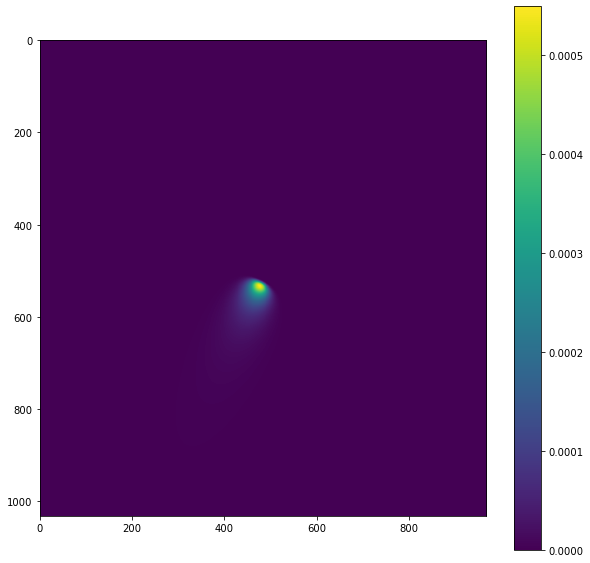

In [10]:
# Some bands have no info for exampple: 21, 9, 23, 24, 38, 42
#import matplotlib.pyplot as plt

# CHANGE HERE THE VALUE BETWEEN 1 TO 48 TO VISUALIZAE THE DIFFERENT BANDS
#i = 5
#path to the file
#fn = old_name[0:5] + df.iloc[i][0] + '.tif'
#print(fn)
#ds = gdal.Open(fn)

# Read raster data
#data_array = ds.GetRasterBand(1).ReadAsArray()
#data_array.shape
#plt.figure(figsize=(10, 10))
#plt.imshow(data_array)
#plt.colorbar()

In [ ]:
# ANOTHER WAY OF DOING THE LAST CONVERSION TO COG

# Writes the netcdf with selected varialbe in the format to be used/read for the gdal translate
#sublayername =  gdal.Open('NETCDF:"{0}":{1}'.format(old_name, var_name ),gdal.GA_ReadOnly)


# Making a loop through all the bands that go from 1 to 48 (which is the leng of the dataframe containing their names)
#Settings for the conversion to COG
#compression =  ' -co COMPRESS=LZW'
#output_format2 = ' -of COG'
#for i in range(1,len(df)):


    #Creates the output name where each TIF file will be stored
    #outname = old_name[0:5] + df.iloc[i][0] + '.tif'
    #inname =  old_name[0:5] + df.iloc[i][0] + 'Reprojected.tif'
    #outname = old_name.replace('gtif_uibk_20201101.nc','') + df.iloc[i][0] + '.tif'
    #print('\n Verifying if outputname is correct. The output name is: ',outname)
    #print('\Verifying input name is correct. Inptu name is:', inname)
    # Performs the GDAL translate to the band 
    #translateOptionText = output_format2 + compression 
    #print('\n Verifying if the command is correct. The command is: ', translateOptionText) 
    #translateOptions = gdal.TranslateOptions(gdal.ParseCommandLine(translateOptionText))
    #gdal.Translate(outname,inname,options = translateOptions)